In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# settings for plots and diagrams
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
plt.rc('mathtext', **{'default':'regular'})
plt.style.use(['seaborn-white', 'seaborn-paper'])

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [10]:
def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.xaxis.set_tick_params(top=False, direction='out', width=1)
    ax.yaxis.set_tick_params(right=False, direction='out', width=1)
    
def save_image(fig, title):
    if title is not None:
        fig.savefig("results/"+title+".png", dpi=300, bbox_inches='tight', transparent=True)
        fig.savefig("results/"+title+".pdf", bbox_inches='tight')

In [6]:
# Load the dataset
n_window_len = 128
file = open('results/mhealth_window_size_' + str(n_window_len) + '.pickle', 'rb')
mhealth_df, mhealth_activities = pickle.load(file)
file.close()

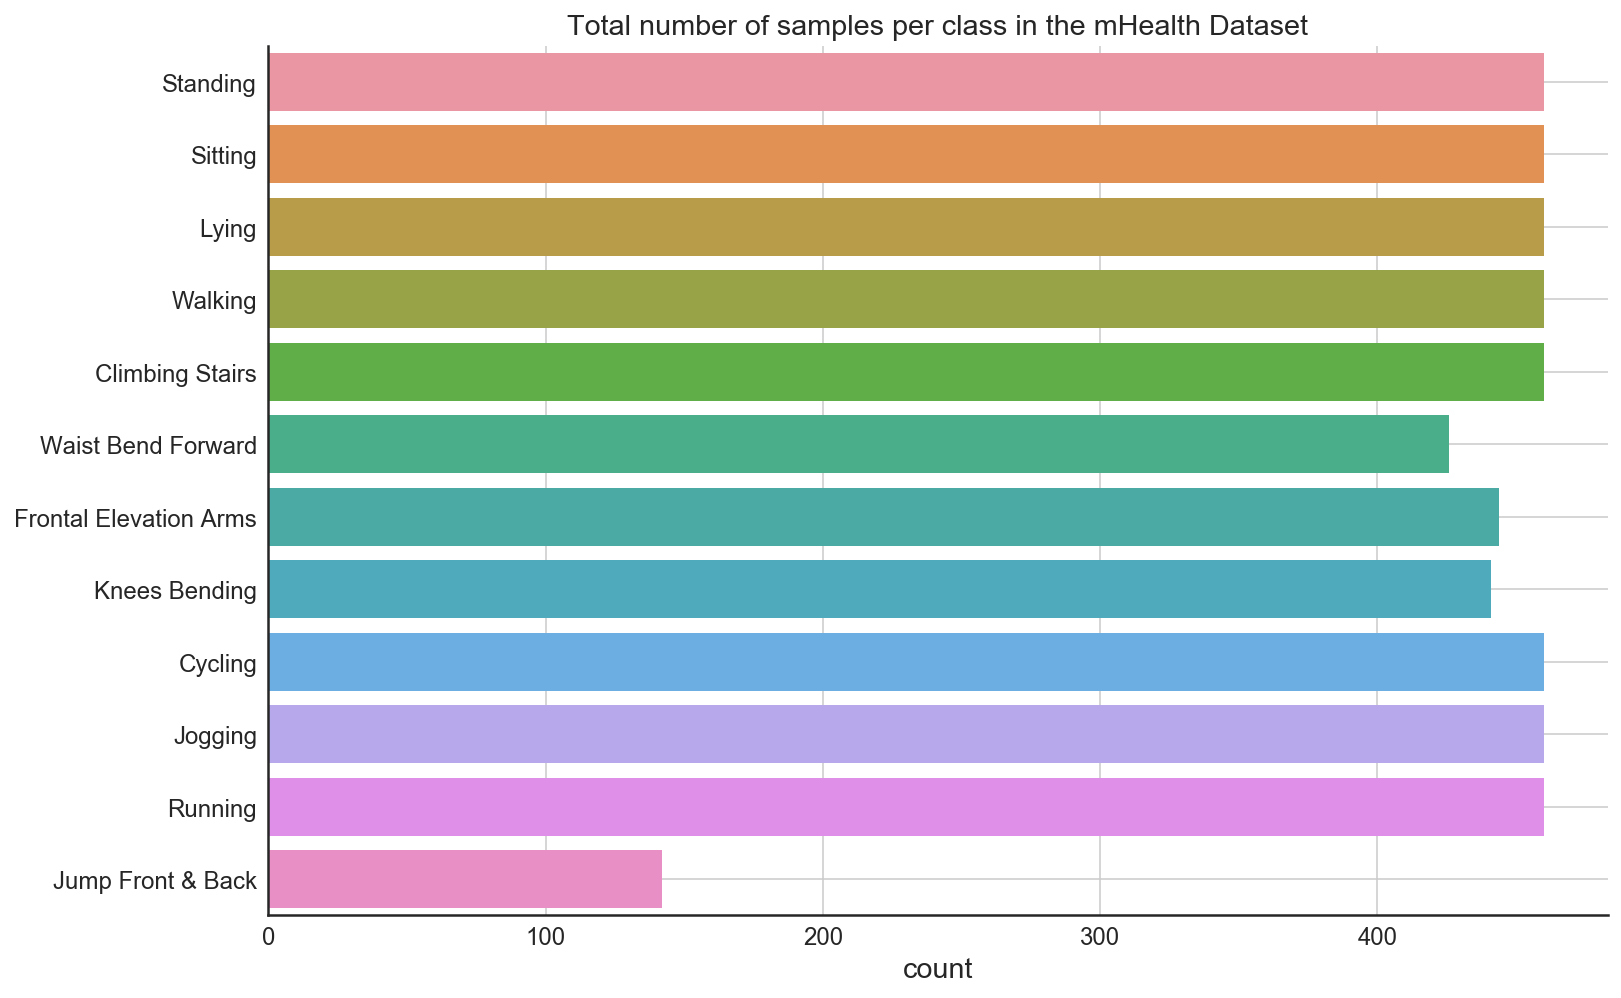

In [11]:
fig = plt.figure(figsize = (12, 8))
ax = sns.countplot(data = mhealth_df, y = 'Class')
ax.set_yticklabels(mhealth_activities)
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_ylabel("")
ax.grid()
stylize_axes(ax)
ax.set_title("Total number of samples per class in the mHealth Dataset")
save_image(fig, "Total number of samples per class in the mHealth Dataset")

In [12]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [13]:
import tensorflow as tf
from tensorflow import keras

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Normalization 

In [15]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer

In [16]:
'''
We need to decide whether should noralize the data or not. And if yes which normalization to use and why. A section of this in the 
report.
'''

def my_train_test_split(data_df, window_length, prepro = "minmax"):
    labels = data_df['Class'].values
    data_df = data_df.drop(['Class'], axis = 1).values
    
    if prepro == 'minmax':
        processor = MinMaxScaler((-1.0, 1.0))
    elif prepro == 'robust':
        processor = RobustScaler()
    elif prepro == 'standard':
        processor = StandardScaler()
    elif prepro == 'norm':
        processor = Normalizer()
        
    data_df = processor.fit_transform(data_df)
    
    x_train, x_test, y_train, y_test = train_test_split(data_df, labels, stratify = labels, random_state = 124, 
                                                        shuffle = True)
    
    x_train = x_train.reshape(-1, window_length, 3)
    x_test = x_test.reshape(-1, window_length, 3)
    
    return x_train, y_train, x_test, y_test

In [17]:
x_train, y_train, x_test, y_test = my_train_test_split(mhealth_df, n_window_len, "minmax")

In [18]:
min(x_train.min(), x_test.min()), max(x_train.max(), x_test.max())

(-1.0, 1.0000000000000004)

In [19]:
x_train.shape

(3849, 128, 3)

In [20]:
n_classes = max(y_train) + 1
n_channels = 3

In [21]:
y_train_hot = keras.utils.to_categorical(y_train)
y_test_hot = keras.utils.to_categorical(y_test)

In [22]:
def get_cnn_network():
    segments = tf.placeholder(tf.float32, [None, 128, n_channels], name='input')
    labels = tf.placeholder(tf.int64, [None])
    training = tf.Variable(True, name='training')

    # Layers in the network 
    conv1 = tf.layers.conv1d(inputs = segments, filters=100, kernel_size=(10), strides=2, activation=tf.nn.relu, name='conv1')
    conv2 = tf.layers.conv1d(inputs = conv1, filters=50, kernel_size=(5), strides=1, activation=tf.nn.relu, name='conv2')
    maxPool1 = tf.layers.max_pooling1d(inputs = conv2, pool_size=3, strides=3, name='maxPool1')
    flat1 = tf.layers.flatten(inputs = maxPool1, name='flat1')
    dense1 = tf.layers.dense(inputs = flat1, units=64, activation=tf.nn.relu, name='dense1')
    dropout1 = tf.layers.dropout(inputs = dense1, rate=0.3, training=training, name='dropout1')
    tf.identity(dropout1, 'features')
    logits = tf.layers.dense(inputs = dropout1, units=n_classes, name='dense2')
    tf.identity(logits, 'logits')

    return segments, labels, logits, training

def make_train_op(logits, labels):
    correct_prediction = tf.equal(tf.argmax(logits, axis=1), labels)
    accuracy_tensor = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    loss_tensor = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits))
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss_tensor, tf.train.get_or_create_global_step())

    return train_op, loss_tensor, accuracy_tensor

def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = labels[idx]
    #labels_shuffle = np.asarray(labels_shuffle.reshape(len(labels_shuffle), 1))
    return data_shuffle, labels_shuffle

def train(sess, train_op, loss_tensor, accuracy_tensor, segments, labels, n_batches):
    for _ in range(n_batches):
        seg_batch, label_batch = next_batch(32, x_train, y_train)
        #seg_batch = seg_batch.reshape([-1, 128, 3])
        sess.run(train_op, feed_dict={segments:seg_batch, labels:label_batch})


In [51]:
tf.reset_default_graph()
segments, labels, logits, training = get_cnn_network()
train_op, loss_tensor, accuracy_tensor = make_train_op(logits, labels)

In [52]:
'''# Creating a dataset object from the numpy data arrays
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_data = train_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_data = test_data.batch(BATCH_SIZE)'''

'# Creating a dataset object from the numpy data arrays\ntrain_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))\ntest_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))\n\nBATCH_SIZE = 32\nSHUFFLE_BUFFER_SIZE = 100\n\ntrain_data = train_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)\ntest_data = test_data.batch(BATCH_SIZE)'

In [53]:
# Training the model
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train(sess, train_op, loss_tensor, accuracy_tensor, segments, labels, n_batches = 10000)

In [57]:
saver = tf.train.Saver()
saver.save(sess,'results/cnn_model_checkpoint.ckpt')
tf.train.write_graph(sess.graph.as_graph_def(), '.', 'results/cnn_model_pbtxt.pbtxt', as_text=True)

'.\\results/cnn_model_pbtxt.pbtxt'

In [58]:
!ls results/

checkpoint
cnn_model_checkpoint.ckpt.data-00000-of-00001
cnn_model_checkpoint.ckpt.index
cnn_model_checkpoint.ckpt.meta
cnn_model_pbtxt.pbtxt
cnn_network.pb
cnn_trained_model_mheatlh.h5
Confusion Matrix for the Test Data.pdf
Confusion Matrix for the Test Data.png
data_preprocessing_MinMaxScaler.pdf
data_preprocessing_MinMaxScaler.png
data_preprocessing_Normalizer.pdf
data_preprocessing_Normalizer.png
data_preprocessing_RobustScaler.pdf
data_preprocessing_RobustScaler.png
data_preprocessing_StandardScaler.pdf
data_preprocessing_StandardScaler.png
mhealth_processed_data_size_128.pickle
mhealth_window_size_128.pickle
tensorflowModel.ckpt.data-00000-of-00001
tensorflowModel.ckpt.index
tensorflowModel.ckpt.meta
Total number of samples per class in the mHealth Dataset.pdf
Total number of samples per class in the mHealth Dataset.png
Training and Validation Loss and Accuracy of the CNN model.pdf
Training and Validation Loss and Accuracy of the CNN model.png


In [72]:
from tensorflow.python.tools import freeze_graph


freeze_graph.freeze_graph('results/cnn_model_pbtxt.pbtxt', "", False, 
                          'results/cnn_model_checkpoint.ckpt', "logits",
                           "save/restore_all", "save/Const:0",
                           'results/cnn_model.pb', True, ""  
                         )

INFO:tensorflow:Restoring parameters from results/cnn_model_checkpoint.ckpt


INFO:tensorflow:Restoring parameters from results/cnn_model_checkpoint.ckpt


INFO:tensorflow:Froze 9 variables.


INFO:tensorflow:Froze 9 variables.


INFO:tensorflow:Converted 9 variables to const ops.


INFO:tensorflow:Converted 9 variables to const ops.


In [60]:
sess.run(training.assign(False))
loss, accuracy = sess.run([loss_tensor, accuracy_tensor],
                         feed_dict={segments: x_test,
                                  labels: y_test})

print("Final loss/accuracy: {:.3f}/{:.3f}".format(loss, accuracy))

Final loss/accuracy: 0.073/0.973


In [27]:
# Lucid Setup
import lucid.optvis
from lucid.misc.io.showing import _image_url, _display_html
from lucid.modelzoo.vision_base import Model
from lucid.misc.io import show, load, save

In [76]:
# ask for suggested arguments
Model.suggest_save_args()

# Please sanity check all inferred values before using this code.
# Incorrect `image_value_range` is the most common cause of feature visualization bugs! Most methods will fail silently with incorrect visualizations!
Model.save(
    input_name=_,                   # TODO (eg. 'input')
    image_shape=_,                   # TODO (eg. [224, 224, 3])
    output_names=_,                   # TODO (eg. ['logits'])
    image_value_range=_,                   # TODO (eg. '[-1, 1], [0, 1], [0, 255], or [-117, 138]')
  )


{'input_name': None,
 'image_shape': None,
 'output_names': None,
 'image_value_range': None}

In [74]:
with sess.as_default():
    Model.save(
        save_url    = 'results/cnn_model.pb',  # Local paths are also fine!
        input_name   = 'input',
        output_names = ['logits'],
        image_shape  = [1, 128, 3],
        image_value_range = [-1.0, 1.0]
      )

INFO:tensorflow:Froze 9 variables.


INFO:tensorflow:Froze 9 variables.


INFO:tensorflow:Converted 9 variables to const ops.


INFO:tensorflow:Converted 9 variables to const ops.


In [75]:
model = Model.load("results/cnn_model.pb")

In [70]:
import lucid.optvis.render as render

In [77]:
render.render_vis(model, "conv1/kernel:0")

ValueError: Shape must be rank 4 but is rank 5 for 'import/conv1/conv1d/Conv2D' (op: 'Conv2D') with input shapes: [1,1,?,?,3], [1,10,3,100].

In [37]:
# To load the network into Lucid, we'll need to save a frozen graph. This is a single graph containing both the graph structure and weights.
def save_frozen_graph(filename):
    output_graph_def = tf.graph_util.convert_variables_to_constants(
      sess,
      tf.get_default_graph().as_graph_def(),
      ['features', 'logits']
    )
    with open(filename, "wb") as f:
        f.write(output_graph_def.SerializeToString())

save_frozen_graph('results/cnn_network.pb')

INFO:tensorflow:Froze 9 variables.


INFO:tensorflow:Froze 9 variables.


INFO:tensorflow:Converted 9 variables to const ops.


INFO:tensorflow:Converted 9 variables to const ops.


In [33]:
class CNNNetwork(Model):
    model_path = '/gdrive/My Drive/Datasets/cnn_network.pb'
    image_shape = [1, 128, 1, 3]
    image_value_range = (-1.0, 1.0)
    input_name = 'input'

model = CNNNetwork()
model.load_graphdef()

In [91]:
obj = objectives.channel("conv1", 1)
_ = render.render_vis(model, obj, transforms=[])

ValueError: ignored

In [0]:
def render_vis(model, objective_f, param_f, steps=512):
    T = render.make_vis_T(model, objective_f, param_f, optimizer=None, transforms=[])
    loss, vis_op, t_segment = T("loss"), T("vis_op"), T("input")
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for step in range(steps):
        sess.run(vis_op)
    return sess.run(t_segment)

In [93]:
# Logits visualization:
logit_segments = []
print("Logit ", end="")
for logit_idx in range(n_classes):
  print("{}...".format(logit_idx), end="")
  with tf.Graph().as_default(), tf.Session():
    segments = render_vis(model, "logits:{}".format(logit_idx),
                      steps=128, param_f=param.color.to_valid_rgb(param.spatial.naive((1,128,3,3))))
    logit_segments.append(segments)

Logit 0...

ValueError: ignored

In [0]:
def get_cnn_model(input_shape, output_classes):
    temp_model = keras.Sequential([
        keras.layers.Conv1D(filters = 100, kernel_size = (10), strides = 2, activation = tf.nn.relu, input_shape = input_shape),
        keras.layers.Conv1D(filters = 50, kernel_size = (5), strides = 1, activation = tf.nn.relu),
        keras.layers.MaxPool1D(pool_size = 3),
        keras.layers.Flatten(),
        keras.layers.Dense(units = 64, activation = tf.nn.relu),
        keras.layers.Dropout(rate = 0.3),
        keras.layers.Dense(units = output_classes, activation = tf.nn.softmax)
    ])
    
    temp_model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(), 
                      metrics = ['accuracy'])
    
    return temp_model
    

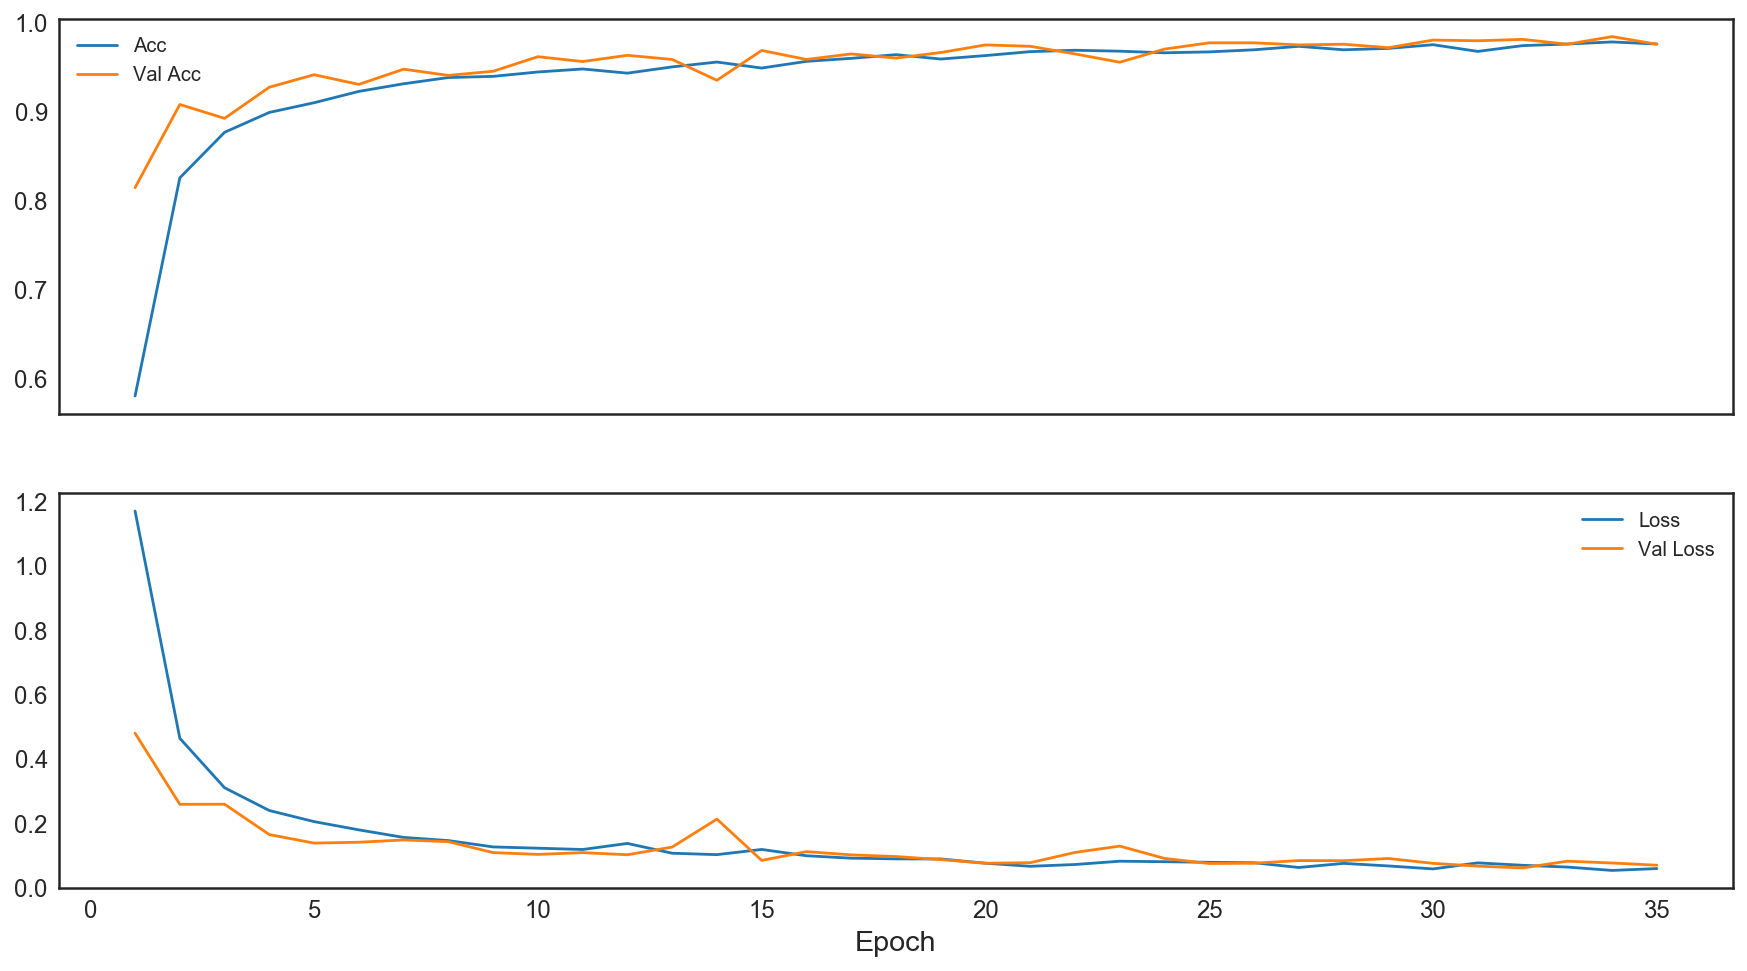

Epoch 00035: early stopping


In [0]:
d1_losses = util.PlotLosses()
d1_early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30,
                                             min_delta = 0.1, verbose = 1, mode = 'min')
d1_callbacks = [d1_losses, d1_early_stop]
d1_model = get_cnn_model((n_window_len, n_channels), n_classes)

d1_history = d1_model.fit(x_train, y_train_hot, batch_size = 32, epochs = 300,
                           validation_data = (x_test, y_test_hot), verbose = 0, callbacks = d1_callbacks)

In [0]:
print(d1_model.evaluate(x_train, y_train_hot))
print(d1_model.evaluate(x_test, y_test_hot))

3849/3849 [==============================] - 1s 176us/step
[0.031958477523939564, 0.9875292283864912]
1284/1284 [==============================] - 0s 165us/step
[0.06825733616530338, 0.9758566978193146]


In [0]:
# Save the processed data for evaluation with adversarial modules
file = open('results/mhealth_processed_data_size_' + str(n_window_len) + '.pickle', 'wb')
pickle.dump([x_train, y_train, x_test, y_test, mhealth_activities], file)
file.close()

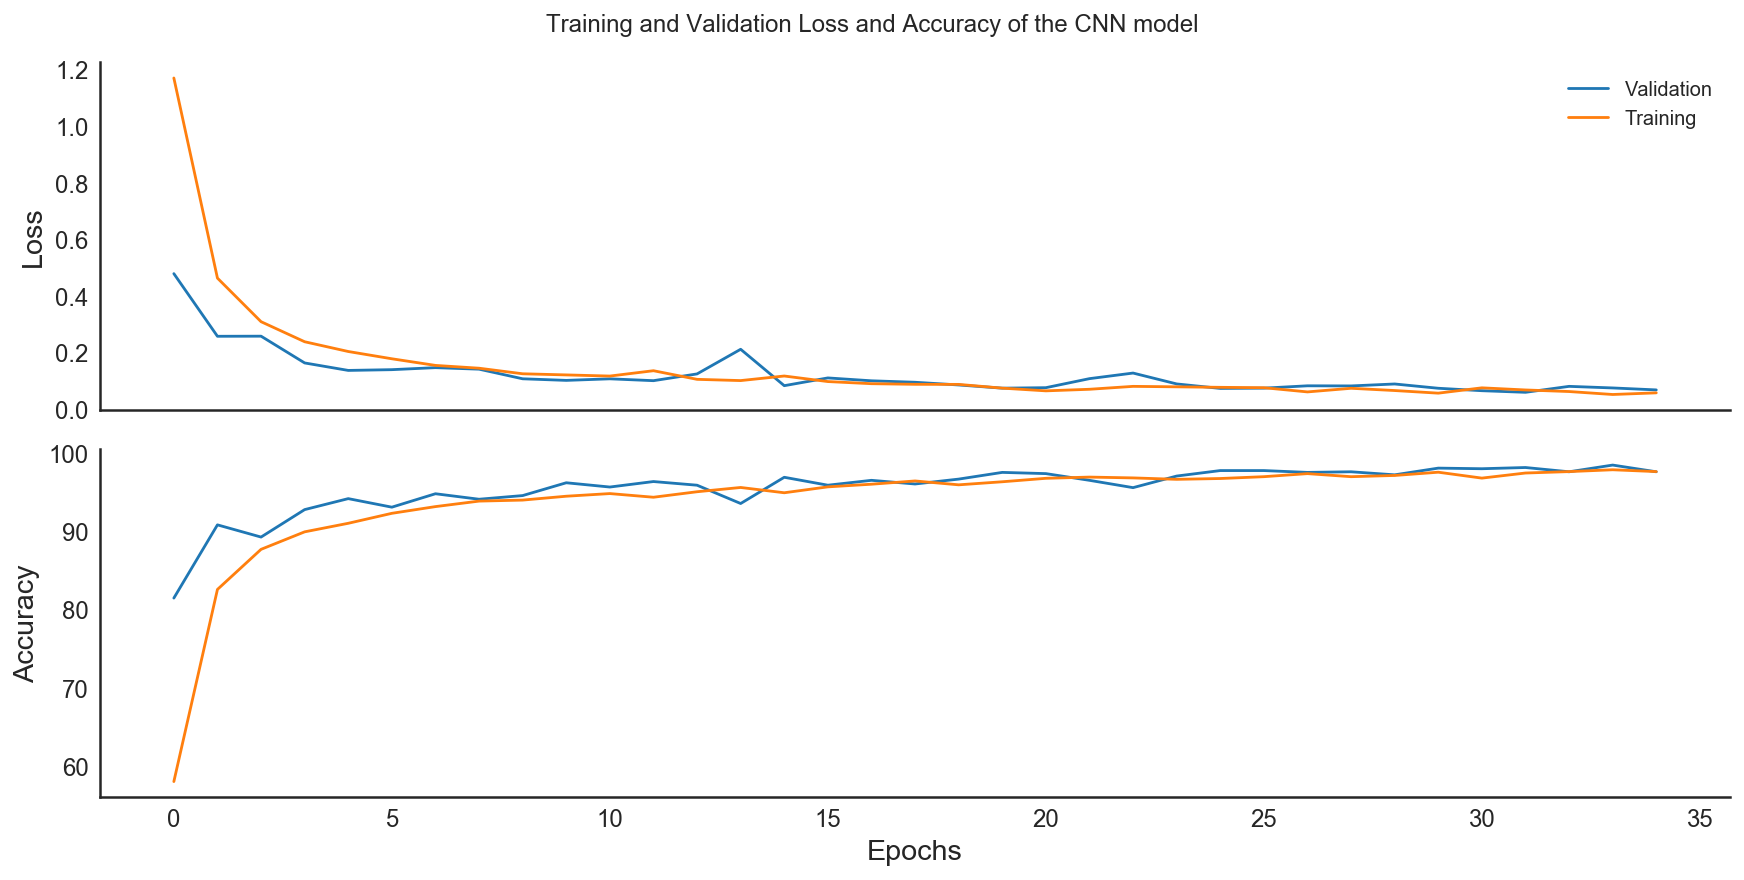

In [0]:
training_outcomes = d1_history.history

fig, axes = plt.subplots(nrows=2, ncols=1, constrained_layout=True, sharex = True, figsize = (12, 6))
axes[0].plot(training_outcomes['val_loss'], label='Validation')
axes[0].plot(training_outcomes['loss'], label='Training')
axes[0].set_ylabel('Loss')
axes[0].set_xticklabels("")
axes[0].legend()
stylize_axes(axes[0])

axes[1].plot([x * 100 for x in training_outcomes['val_acc']], label='Validation')
axes[1].plot([x * 100 for x in training_outcomes['acc']], label='Training')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel("Epochs")
axes[1].set_xticklabels(axes[1].get_xticks().astype(int))
stylize_axes(axes[1])

fig.suptitle("Training and Validation Loss and Accuracy of the CNN model")
save_image(fig, "Training and Validation Loss and Accuracy of the CNN model")

In [0]:
y_pred = np.argmax(d1_model.predict(x_test),  axis=1)

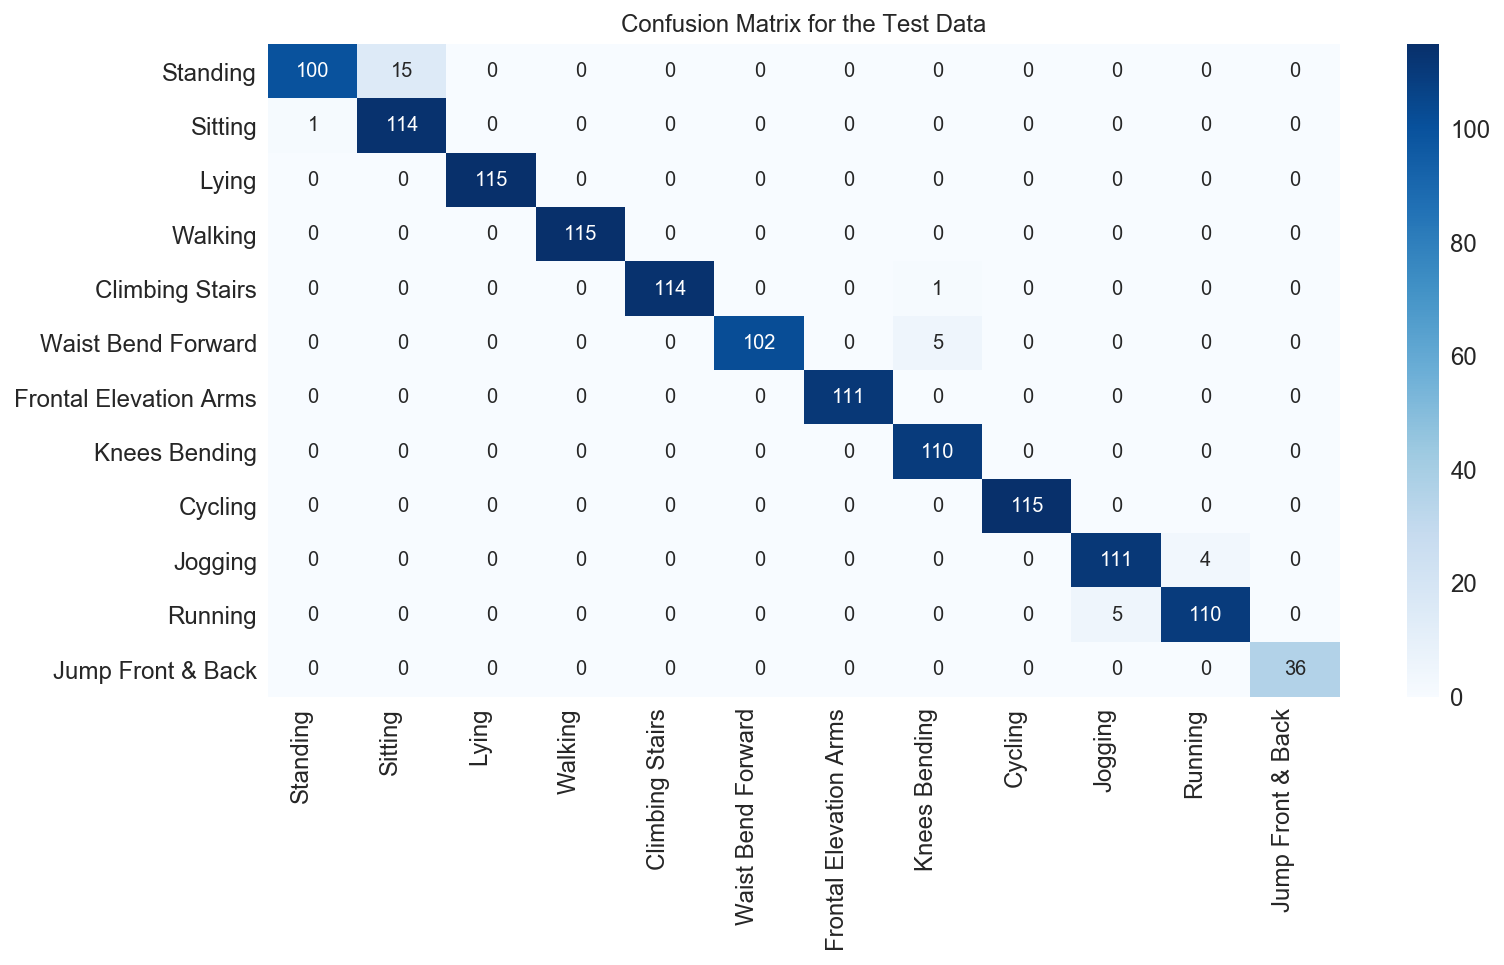

In [0]:
c_fig, c_ax = util.print_confusion_matrix(y_test, y_pred, np.arange(n_classes),
                           "Confusion Matrix for the Test Data", mhealth_activities)

In [0]:
stylize_axes(c_ax)
save_image(c_fig, "Confusion Matrix for the Test Data")

In [0]:
# Save the trained model to be used with adversarial module
d1_model.save("results/cnn_trained_model_mheatlh.h5")

In [0]:
# Load the saved model 
new_model = tf.keras.models.load_model('results/cnn_trained_model_mheatlh.h5')